In [2]:
import pandas as pd
from numpy import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pickle

Utility functions

In [23]:
def zipf_distribution(s, N):
    c = sum((1 / arange(1, N + 1) ** s))
    return arange(1, N + 1) ** (-s) / c


def show_heatmap(rs):
    slots = []
    DT = 1000
    for i in range(rs.size // DT):
        x = zeros(N)
        slot = pd.DataFrame(rs[i * DT: (i + 1) * DT], columns=['R'])
        slot['c'] = 1
        slot = slot.groupby('R').count().values
        slot = slot / slot.sum()
        slots.append(slot.flatten())
    slots = pd.DataFrame(slots)
    return sns.heatmap(slots.T)


def to_vec(x):
    y = np.zeros(N)
    y[x.R] = x.t
    return y


def plot_trace(rs):
    rs = np.asarray(rs)
    df = pd.DataFrame(array([rs[:100_000], arange(rs[:100_000].size) * .01]).T, columns=['R', 't']).sample(frac=1).iloc[
         :10_000]
    fig, ax = plt.subplots()
    plt.scatter(df.t, df.R, s=0.05, color='blue')
    ax.set(ylabel='Item ID', xlabel='Time')

### Fixed / Sliding popularity IRM requests

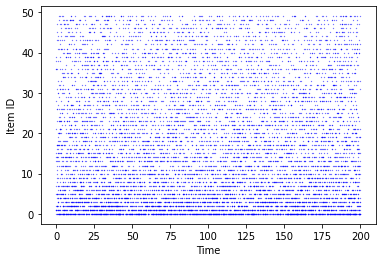

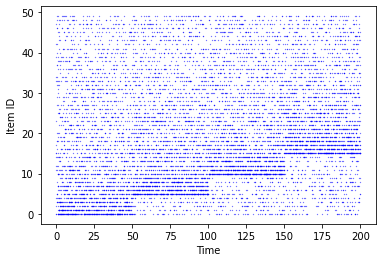

In [24]:
for roll_amount in [0, 5]:
    N = 50
    T = 5_000 * 4
    s = .6
    p = zipf_distribution(s, N)
    rs = random.choice(arange(N), p=p, size=T // 4)
    p = roll(p, roll_amount)
    rs = hstack((rs, random.choice(arange(N), p=p, size=T // 4)))
    p = roll(p, roll_amount)
    rs = hstack((rs, random.choice(arange(N), p=p, size=T // 4)))
    p = roll(p, roll_amount)
    rs = hstack((rs, random.choice(arange(N), p=p, size=T // 4)))
    if roll_amount == 0:
        pickle.dump(rs, open("traces/fixed_popularity_catalog_50.pkl", "wb"))
    else:
        pickle.dump(rs, open("traces/changing_popularity_catalog_50.pkl", "wb"))

    plot_trace(rs)

### Poisson Shot Noise model

In [25]:
portions = array([.044, .069, .041, .062, 1.196])
vs = array([86.4, 41.9, 59.5, 36.9, 25.7]) * 3
ls = array([1.14, 3.36, 6.40, 10.53, 24.61])
portions = portions / sum(portions) * 100
portions = np.hstack((0, np.round(portions).cumsum())).astype(int)
N = 100
L = ones(N)
V = ones(N)
for i in range(len(portions) - 1):
    V[portions[i]:portions[i + 1]] = vs[i]
    L[portions[i]:portions[i + 1]] = ls[i]

In [26]:
gamma = 5
arrival_new_request = random.exponential(1 / gamma, N)
Tau = cumsum(arrival_new_request)
random.shuffle(Tau)

Rs = []
for i in range(N):
    if V[i] != 0:
        vm = V[i]
        lm = L[i]
        tau_m = Tau[i]
        sigma = L[i]
        T = 0
        while True:
            arr = random.exponential(sigma / vm, 1)
            T = T + float(arr)
            if (T > L[i]):
                break
            Rs.append([i, tau_m + T])

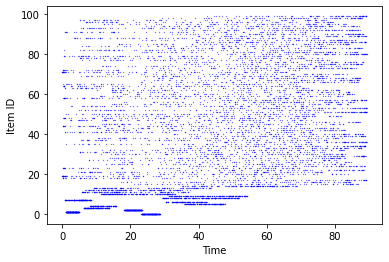

In [28]:
R = pd.DataFrame(Rs, columns=['R', 't', ]).sort_values(by='t').R.values
pickle.dump(R, open("traces/PSN_catalog_100.pkl", "wb"))
plot_trace(R)

### Truncated Akamai trace

In [19]:
# rs = pickle.load(open("traces/Akamai_CDN_catalog_1000.pkl", "rb"))
# catalog = pd.DataFrame({'R': rs, 'c': 1}).groupby('R').c.count().sort_values(ascending=False).iloc[:1000].index
# rs = rs[isin(rs, catalog)]
#
# Mapper = pd.DataFrame(array([unique(rs), arange(1000)]).T)
# Mapper.columns = ['R', 'C']
# Mapper.set_index('R', inplace=True)
# rs = Mapper.loc[rs].C.values
# plot_trace(rs)
# pickle.dump(rs[:100_000], open("traces/Akamai_CDN_catalog_1000.pkl", "wb"))

### Adversarial traces.

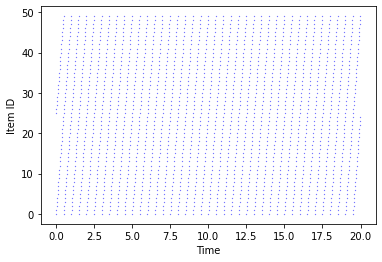

In [20]:
rs = []

cat1 = arange(25)
cat2 = arange(25, 50)
for i in range(1_000):
    rs += [cat1[i % 25]]
    rs += [cat2[i % 25]]
pickle.dump(array(rs), open("traces/oscillator.pkl", "wb"))
plot_trace(rs)

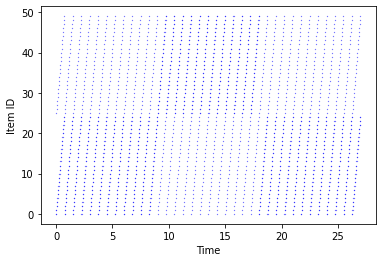

In [21]:
rs = []

cat1 = arange(25)
cat2 = arange(25, 50)
for i in range(300):
    rs += [cat1[i % 25]] * 2
    rs += [cat2[i % 25]]
for i in range(300):
    rs += [cat1[i % 25]]
    rs += [cat2[i % 25]] * 2
for i in range(300):
    rs += [cat1[i % 25]] * 2
    rs += [cat2[i % 25]]
pickle.dump(array(rs), open("traces/changing_oscillator.pkl", "wb"))
plot_trace(rs)

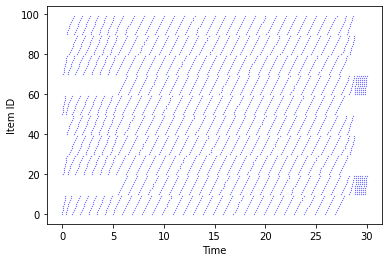

In [22]:
shots = []
N=50
cat1 = arange(50)
cat2 = arange(50, 100)
gamma = 1
arrival_new_request = random.exponential(1 / gamma, N // 10)
Tau = cumsum(arrival_new_request)
random.shuffle(Tau)

for k in range(5):
    for i in range(300):
        shots.append([cat1[i % 10 + 10 * k], Tau[k] + .05 * i])
        shots.append([cat2[i % 10 + 10 * k], Tau[k] + .05 * i])
rs = pd.DataFrame(shots, columns=['R', 't', ]).sort_values(by='t').R.values
pickle.dump(array(rs), open("traces/SN_oscillator.pkl", "wb"))
plot_trace(rs)